In [98]:
### Prerna Singh
# 
# Isolate cell regions and non-cell regions for given 3D sliced Clarity images of the brain
# Use a brain-wide illumination correction for intensity
# Extract 10x the non-cell data than cell data by selecting points within 20 pixels x y and z of cells
#

#import scipy.io
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd
import cv2

In [99]:
#image source path
file_path_img = os.path.join('12L_bias_corrected')
list = os.listdir(file_path_img)

In [100]:
#preprocess the csv with file labels
fileLabelCSV = pd.read_csv('ENTANGLtrainingdata/E12L-training.csv')

#make ordered lists of each coordinate dimension
xfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): X (px)']).to_list()
yfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): Y (px)']).to_list()
zfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): Z (px)']).to_list()
      
ROI = np.zeros((len(xfileLabelCSV),12,12,12))

#measured cells on neuroglancer and found that none were over 10 voxels
#create a list of ranges +-6 from the cell coordinate that are invalid when accumulating non-cell regions
x_invalid=[]
y_invalid=[]
z_invalid=[]
for index0 in range(0,len(xfileLabelCSV)):
    voxel = np.zeros((12,12,12))
    #current coordinates
    xcoord = int(xfileLabelCSV[index0])
    ycoord = int(yfileLabelCSV[index0])
    zcoord = int(zfileLabelCSV[index0])
    
    #for the ncrs
    x_invalid+=[*range(int(xfileLabelCSV[index0])-6,int(xfileLabelCSV[index0])+6)]
    y_invalid+=[*range(int(yfileLabelCSV[index0])-6,int(yfileLabelCSV[index0])+6)]
    z_invalid+=[*range(int(zfileLabelCSV[index0])-6,int(zfileLabelCSV[index0])+6)]
    
    
    #for every z, append the x&ys
    for index, i in enumerate(range(zcoord-6,zcoord+6)):
        for file in list:
            if str("tif") in str(file):
                if len(str(i))==1:
                    i=str("000"+str(i))
                if len(str(i))==2:
                    i=str("00"+str(i))
                if len(str(i))==3:
                    i=str("0"+str(i))
                if str(i) in str(file).split("_")[7]:
                    scan1 = np.asarray(Image.open(file_path_img + '/'+file))
                    scan = np.zeros(scan1.shape)
                    scan = cv2.normalize(scan1,scan, 0, 255, cv2.NORM_MINMAX)
                    plane = scan[xcoord-6:xcoord+6,ycoord-6:ycoord+6]
                    #plt.imshow(plane)
                    #plt.show()
        voxel[index]=np.asarray(plane)
    ROI[index0]=np.asarray(voxel)

print('Total number of CellRegions: ', len(zfileLabelCSV))

Total number of CellRegions:  190


In [101]:
np.save('ROI12L_bias_corrected.npy', ROI)

In [102]:
#export cell coordinates as .npy
xcoordinate=(fileLabelCSV['Center of Mass (Geometry): X (px)']).to_numpy()
ycoordinate=(fileLabelCSV['Center of Mass (Geometry): Y (px)']).to_numpy()
zcoordinate=(fileLabelCSV['Center of Mass (Geometry): Z (px)']).to_numpy()

In [103]:
#number of non-coding regions we want to isolate, lets say 515, same as number of cell regions
nNCMB = len(zfileLabelCSV)*10
NCR = []

#have 11 different coordinates for 1 non-cell region
for index0 in range(0,len(xfileLabelCSV)):
    #current coordinates
    xcoord = int(xfileLabelCSV[index0])
    ycoord = int(yfileLabelCSV[index0])
    zcoord = int(zfileLabelCSV[index0])
    ncrcell=[]
    while (len(ncrcell)) < 10:
        x_random = random.randint(7,20)
        y_random = random.randint(7,20)
        z_random = random.randint(7,20)
        #proceed =1
        #print("Random x,y,z for Non CMB Region:", x_random,y_random,z_random)

        #for i in x_invalid:
        #    if x_random == i:
        #        #print('x_false')
        #        proceed = 0
        #for i in y_invalid:
        #    if y_random == i:
        #        #print('y_false')
        #        proceed = 0
        #for i in z_invalid:
        #    if z_random == i:
        #        #print('z_false')
        #        proceed = 0
        if len(ncrcell) %8==0:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord+y_random,zcoord+z_random])
        elif len(ncrcell) %8==1:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord+y_random,zcoord+z_random])
        elif len(ncrcell) %8==2:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord-y_random,zcoord+z_random])
        elif len(ncrcell) %8==3:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord+y_random,zcoord-z_random])
        elif len(ncrcell) %8==4:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord-y_random,zcoord-z_random])
        elif len(ncrcell) %8==5:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord+y_random,zcoord-z_random])
        elif len(ncrcell) %8==6:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord-y_random,zcoord+z_random])
        else:
            ncrcell.append([xcoord-x_random,ycoord-y_random,zcoord-z_random])
    for i in ncrcell:
        NCR.append(i)
    #print(len(NCR))
print("%s non-CMB regions were isolated." %(len(NCR)), "Adding to the master dictionary.")

1900 non-CMB regions were isolated. Adding to the master dictionary.


In [104]:
NCR_total = np.zeros((len(NCR),12,12,12))

for index0 in range(0,len(NCR)):
    voxel = np.zeros((12,12,12))
    
    #current coordinates
    xcoord = int(NCR[index0][0])
    ycoord = int(NCR[index0][1])
    zcoord = int(NCR[index0][2])

    #for every z, append the x&ys
    for index,i in enumerate(range(zcoord-6,zcoord+6)):
        for file in list:
            if str("tif") in str(file):
                if len(str(i))==1:
                    i=str("000"+str(i))
                if len(str(i))==2:
                    i=str("00"+str(i))
                if len(str(i))==3:
                    i=str("0"+str(i))
                if str(i) in str(file).split("_")[7]:
                    scan1 = np.asarray(Image.open(file_path_img + '/'+file))
                    scan = np.zeros(scan1.shape)
                    scan = cv2.normalize(scan1,scan, 0, 255, cv2.NORM_MINMAX)
                    plane = scan[xcoord-6:xcoord+6,ycoord-6:ycoord+6]
        voxel[index] = np.asarray(plane)
    NCR_total[index0]=np.asarray(voxel)

In [105]:
np.save('NCR12L_bias_correctedjere.npy',np.asarray(NCR_total))

In [106]:
NCR[2]

[1459, 796, 380]

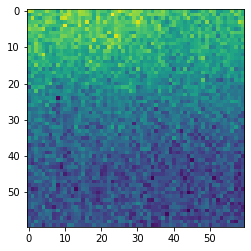

In [107]:
plt.imshow(scan[NCR[34][0]-30:NCR[34][0]+30,NCR[34][1]-30:NCR[34][1]+30])
plt.show()

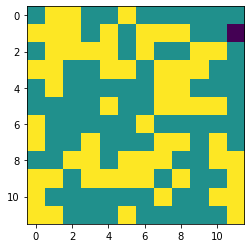

In [108]:
plt.imshow(NCR_total[34][5])